# Purpose

This notebook is to do analysis on the distribution of listening events across Freebase genres, minus the AllMusic genres, by looking at how many top genres is takes to cover a majority of listening events
## Loading Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import os
import swifter

## Preparing Data

In [2]:
allMusicGenres = pd.read_parquet('../data/LastFM1bKidArtistToAllMusicGenre.gzip.parquet')
allMusicGenres = list(allMusicGenres['Genre'].cat.categories)
allMusicGenres

['ALTERNATIVE',
 'BLUES',
 "CHILDREN'S",
 'CLASSICAL',
 'COUNTRY',
 'EASY LISTENING',
 'ELECTRONIC',
 'FOLK',
 'HEAVY METAL',
 'JAZZ',
 'NEW AGE',
 'POP',
 'PUNK',
 'RAP',
 'REGGAE',
 'RNB',
 'ROCK',
 'SPOKEN WORD',
 'VOCAL',
 'WORLD']

In [3]:
artistToGenre = pd.read_parquet('../data/LastFM1bKidArtistToFreebaseGenre.gzip.parquet')
artistToGenre.head(5)

,Artist,Genre
0,MEGADETH,HEAVY METAL
1,DREAM THEATER,HEAVY METAL
2,AMON AMARTH,HEAVY METAL
3,ALTER BRIDGE,HEAVY METAL
4,LIMP BIZKIT,HEAVY METAL


In [4]:
artistToGenre = artistToGenre[artistToGenre['Genre'].isin(allMusicGenres) == False]

### Ranking Genres from most listened to least

In [5]:
genreRanking = pd.read_parquet('../data/LastFM1bKidListeningEventsWithUsers', columns = ['Artist', 'User Id'])
genreRanking = genreRanking.groupby(['Artist']).agg(ArtistCount = ('User Id', 'count')).reset_index()
genreRanking.head(5)

,Artist,ArtistCount
0,! WWW.POLSKIE-MP3.TK ! AFRO KOLEKTYW,1
1,! WWW.POLSKIE-MP3.TK ! AKURAT,21
2,! WWW.POLSKIE-MP3.TK ! ALKATRAZ,43
3,! WWW.POLSKIE-MP3.TK ! BANACH & INDIOS BRAVOS,4
4,! WWW.POLSKIE-MP3.TK ! BRYGADA KRYZYS,11


In [6]:
genreRanking = genreRanking.merge(artistToGenre, on = 'Artist')
genreRanking.drop(columns = ['Artist'], inplace = True)
genreRanking.head(5)

,ArtistCount,Genre
0,571,DANCE
1,571,ALTERNATIVE ROCK
2,571,INDIE
3,571,INDIE ROCK
4,571,PSYCHEDELIC


In [7]:
genreRanking = genreRanking.groupby(['Genre'], observed = True).agg(Count = ('ArtistCount', 'sum')).reset_index()
genreRanking.head(5)

,Genre,Count
0,DANCE,7144843
1,ALTERNATIVE ROCK,16203257
2,INDIE,15741135
3,INDIE ROCK,10699384
4,PSYCHEDELIC,4495762


### User to Artist counts

In [8]:
userToArtistCounts = pd.read_parquet('../data/LastFM1bKidListeningEventsWithUsers', columns = ['Education Level', 'Age', 'Artist'])
userToArtistCounts.drop(columns = ['Partition'], inplace = True)
userToArtistCounts.head(5)

,Education Level,Age,Artist
0,HS,16,I BREAK HORSES
1,HS,16,TAYLOR SWIFT
2,HS,16,HIM
3,HS,16,AMARANTHE
4,HS,16,AMARANTHE


In [9]:
userToArtistCounts = userToArtistCounts.groupby(['Education Level', 'Age', 'Artist'], observed = True).agg(Count = ('Artist', 'count')).reset_index()
userToArtistCounts.head(5)

,Education Level,Age,Artist,Count
0,HS,15,I BREAK HORSES,5
1,HS,15,TAYLOR SWIFT,15038
2,HS,15,HIM,2180
3,HS,15,AMARANTHE,1792
4,HS,15,SERENITY,6


### Top X Genres to Listening Event Counts

In [10]:
calculations = pd.DataFrame({'Genres': itertools.accumulate(map(lambda x: [x], genreRanking['Genre'].to_list()))})
calculations.head(5)

,Genres
0,[DANCE]
1,"[DANCE, ALTERNATIVE ROCK]"
2,"[DANCE, ALTERNATIVE ROCK, INDIE]"
3,"[DANCE, ALTERNATIVE ROCK, INDIE, INDIE ROCK]"
4,"[DANCE, ALTERNATIVE ROCK, INDIE, INDIE ROCK, P..."


In [11]:
def CountListeningEventsIn(genres):
    result = artistToGenre[artistToGenre['Genre'].isin(genres)][['Artist']].drop_duplicates()
    result = userToArtistCounts.merge(result, on = 'Artist')
    result = result.groupby(['Education Level', 'Age'], observed = True).agg(Total = ('Count', 'sum'))
    result = result.rename(columns = {'Total': len(genres)})
    
    return result

data = calculations['Genres'].swifter.allow_dask_on_strings(enable = True).apply(CountListeningEventsIn)
data = pd.concat(data.to_list(), axis = 1)
data

Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

1         2         3         4         5     \
Education Level Age                                                    
HS              15   1007796   2595906   2947001   2961394   3024791   
                16   1899327   5531284   6370112   6407237   6584738   
                17   3485678  10949581  12771190  12850473  13255094   
GS              6      52974    132315    161663    162715    176171   
                7      16969     40023     54403     54649     57545   
                8      49233    105368    127672    129189    132408   
                9       2671      6127      7330      7354     10224   
                10     32942    101942    124085    125663    128944   
                11     49973    106149    138005    139066    145408   
MS              12     51687     71804     90743     91113    105693   
                13    117521    316847    365241    367267    380333   
                14    363953    970275   1085258   1090912   1116025   

                         6         7         8         9         10    ...  \
Education Level Age                                                    ...   
HS              15    3228597   3271447   3275734   3278193   3301385  ...   
                16    7102366   7212407   7221591   7237870   7303968  ...   
                17   14326530  14594351  14611907  14637095  14760983  ...   
GS              6      193826    196974    197093    197326    198882  ...   
                7       67148     70295     70552     70695     72152  ...   
                8      135377    135637    135767    135810    136188  ...   
                9       12889     13460     13462     13462     13869  ...   
                10     132231    136520    136548    136939    137218  ...   
                11     149870    150664    150684    150841    152904  ...   
MS              12     125560    128361    128471    128753    130775  ...   
                13     403985    408633    409497    410594    413620  ...   
                14    1196719   1208196   1209522   1212626   1221206  ...   

                         1301      1302      1303      1304      1305  \
Education Level Age                                                     
HS              15    4183841   4183841   4183841   4183841   4183841   
                16    9504385   9504385   9504385   9504385   9504385   
                17   19211539  19211539  19211539  19211540  19211540   
GS              6      289047    289047    289047    289047    289047   
                7       87734     87734     87734     87734     87734   
                8      172718    172718    172718    172718    172718   
                9       16258     16258     16258     16258     16258   
                10     160579    160579    160579    160579    160579   
                11     190202    190202    190202    190202    190202   
MS              12     161661    161661    161661    161661    161661   
                13     541468    541468    541468    541468    541468   
                14    1601496   1601496   1601496   1601496   1601496   

                         1306      1307      1308      1309      1310  
Education Level Age                                                    
HS              15    4183841   4183841   4183841   4183841   4183841  
                16    9504385   9504385   9504385   9504385   9504385  
                17   19211545  19211558  19211558  19211558  19211558  
GS              6      289047    289047    289047    289047    289047  
                7       87734     87734     87734     87734     87734  
                8      172718    172718    172718    172718    172718  
                9       16258     16258     16258     16258     16258  
                10     160579    160579    160579    160579    160579  
                11     190202    190202    190202    190202    190202  
MS              12     161661    161661    161661    161661    161661  
                13     541468    54

## Graphs 
### by Age

In [12]:
graphData = data.fillna(0).reset_index().drop(columns = 'Education Level').set_index('Age').unstack().reset_index().rename(columns = {'level_0': 'Top X', 0: 'Listening Event Count'})
temp = graphData.groupby(['Age']).agg(Total = ('Listening Event Count', 'max'))
graphData = graphData.merge(temp, on = 'Age')
graphData['% of Listening Events'] = graphData['Listening Event Count'] / graphData['Total']
graphData

,Top X,Age,Listening Event Count,Total,% of Listening Events
0,1,15,1007796,4183841,0.240878
1,2,15,2595906,4183841,0.620460
2,3,15,2947001,4183841,0.704377
3,4,15,2961394,4183841,0.707817
4,5,15,3024791,4183841,0.722970
...,...,...,...,...,...
15715,1306,14,1601496,1601496,1.000000
15716,1307,14,1601496,1601496,1.000000
15717,1308,14,1601496,1601496,1.000000
15718,1309,14,1601496,1601496,1.000000


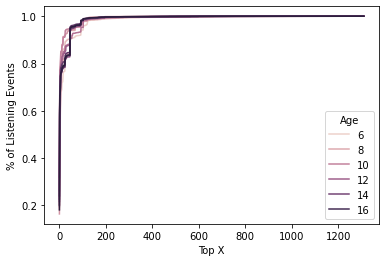

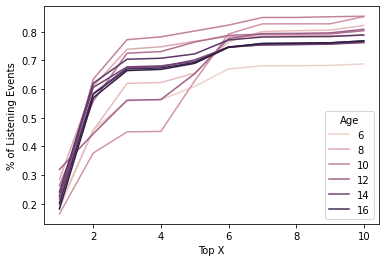

In [13]:
sns.lineplot(data = graphData, x = 'Top X', hue = 'Age', y = '% of Listening Events')
plt.show()
sns.lineplot(data = graphData[graphData['Top X'] <= 10], x = 'Top X', hue = 'Age', y = '% of Listening Events');

### by Education Level

In [14]:
graphData = data.fillna(0).reset_index().drop(columns = 'Age').groupby('Education Level').sum().unstack().reset_index().rename(columns = {'level_0': 'Top X', 0: 'Listening Event Count'})
temp = graphData.groupby(['Education Level']).agg(Total = ('Listening Event Count', 'max'))
graphData = graphData.merge(temp, on = 'Education Level')
graphData['% of Listening Events'] = graphData['Listening Event Count'] / graphData['Total']
graphData

,Top X,Education Level,Listening Event Count,Total,% of Listening Events
0,1,GS,204762,916538,0.223408
1,2,GS,491924,916538,0.536720
2,3,GS,613158,916538,0.668994
3,4,GS,618636,916538,0.674970
4,5,GS,650700,916538,0.709954
...,...,...,...,...,...
3925,1306,HS,32899771,32899784,1.000000
3926,1307,HS,32899784,32899784,1.000000
3927,1308,HS,32899784,32899784,1.000000
3928,1309,HS,32899784,32899784,1.000000


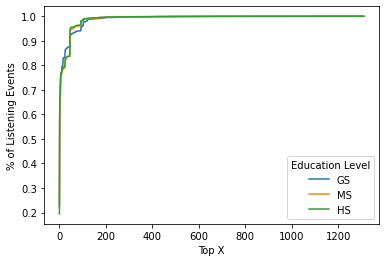

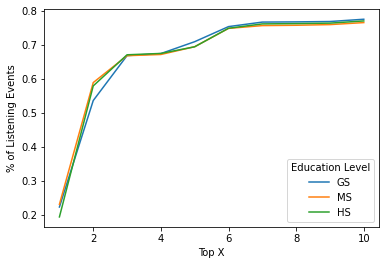

In [15]:
sns.lineplot(data = graphData, x = 'Top X', hue = 'Education Level', y = '% of Listening Events')
plt.show()
sns.lineplot(data = graphData[graphData['Top X'] <= 10], x = 'Top X', hue = 'Education Level', y = '% of Listening Events');